   - 학습 데이터 (user_id : 10000 ~ 24999, 15000명)


			- train_err_data.csv : 시스템에 발생한 에러 로그

			- train_quality_data.csv : 시스템 퀄리티 로그

			- train_problem_data.csv : 사용자 불만 및 불만이 접수된 시간


   - 테스트 데이터(user_id : 30000 ~ 44998, 14999명)


			- test_err_data.csv : 시스템에 발생한 에러 로그

			- test_quality_data.csv : 시스템 퀄리티 로그

			- sample_submission.csv : 사용자 불만 확률(0~1) (제출용)

## 사용할 Module & Data 불러오기 

In [27]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import missingno as msno
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
train_err_df =pd.read_csv('../data/train_err_data.csv')
train_problem_df =pd.read_csv('../data/train_problem_data.csv')
train_quality_df =pd.read_csv('../data/train_quality_data.csv')
# err data 는 user_id 15000 명의 대한것이다

/var/folders/t3/j8459bg97zb7x34h0c_jgnlr0000gn/T/ipykernel_1265/480549363.py:3: DtypeWarning: Columns (10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  train_quality_df =pd.read_csv('../data/train_quality_data.csv')


### 불만접수를 err 데이터의 있는 모든 유저 가 불만접수를 했는지 확인

In [5]:
train_err_df.user_id.value_counts()
train_problem_df.user_id.value_counts()
train_quality_df.user_id.value_counts()
#quality user_id 8281
#problem user_id 5000
#err user_id     15000
#에러가 발생한 모든 유저가 불만 접수를 한것이 아님
# 그러면 특정 유저

24934    222186
20546    195538
15570    175730
20352     83680
11041     66093
          ...  
20099         1
21960         1
21076         1
20618         1
13525         1
Name: user_id, Length: 15000, dtype: int64

In [7]:
train_quality_df.info() 
train_problem_df.info()
train_err_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        828624 non-null  int64  
 1   user_id     828624 non-null  int64  
 2   fwver       788544 non-null  object 
 3   quality_0   684192 non-null  float64
 4   quality_1   828624 non-null  int64  
 5   quality_2   788511 non-null  float64
 6   quality_3   828624 non-null  int64  
 7   quality_4   828624 non-null  int64  
 8   quality_5   828604 non-null  object 
 9   quality_6   828624 non-null  int64  
 10  quality_7   828624 non-null  object 
 11  quality_8   828624 non-null  object 
 12  quality_9   828624 non-null  object 
 13  quality_10  828624 non-null  object 
 14  quality_11  828624 non-null  int64  
 15  quality_12  828624 non-null  int64  
dtypes: float64(2), int64(8), object(6)
memory usage: 101.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 

In [36]:
null_columns = train_quality_df.columns[train_quality_df.isnull().sum() > 0].to_list()
# 이거 왜 되지 ;; 여러개 의 행의 빈값 있는 것만 찾으려했는데 조건식 만들기가 힘드네 
for column in null_columns:
    display(train_quality_df[train_quality_df[column].isnull()])

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
38316,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38317,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38318,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38319,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38320,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828331,20201109232000,24982,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
828332,20201109232000,24982,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
828333,20201109232000,24982,NaN,NaN,-1,NaN,0,0,-1,-1,0,0,0,0,-1,0
828334,20201109232000,24982,NaN,NaN,-1,NaN,0,0,-1,-1,0,0,0,0,-1,0


,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
3852,20201104022000,10080,03.11.1149,NaN,-1,-1.0,0,0,-1,-1,0,0,3,1,-1,0
3853,20201104022000,10080,03.11.1149,NaN,-1,-1.0,0,0,-1,-1,0,0,3,1,-1,0
3854,20201104022000,10080,03.11.1149,NaN,0,2.0,0,0,1,0,0,0,3,1,0,0
3855,20201104022000,10080,03.11.1149,NaN,0,1.0,0,0,0,0,0,0,3,1,0,0
3856,20201104022000,10080,03.11.1149,NaN,0,0.0,0,0,0,0,0,0,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828511,20201121113000,24990,03.11.1167,NaN,-1,-1.0,0,0,-1,-1,0,0,0,1,-1,0
828512,20201121113000,24990,03.11.1167,NaN,-1,-1.0,0,0,-1,-1,0,0,0,1,-1,0
828513,20201121113000,24990,03.11.1167,NaN,0,0.0,0,0,0,0,0,0,0,1,0,0
828514,20201121113000,24990,03.11.1167,NaN,0,0.0,0,0,0,0,0,0,0,1,0,0


,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
38316,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38317,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38318,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38319,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
38320,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828331,20201109232000,24982,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
828332,20201109232000,24982,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0
828333,20201109232000,24982,NaN,NaN,-1,NaN,0,0,-1,-1,0,0,0,0,-1,0
828334,20201109232000,24982,NaN,NaN,-1,NaN,0,0,-1,-1,0,0,0,0,-1,0


,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
58907,20201128234000,11154,04.33.1261,0.0,0,0.0,0,0,NaN,0,0,0,0,"200,496",0,2
150490,20201126231000,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,11,0,0,"843,420",0,3
150491,20201126231000,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,11,0,0,"843,420",0,3
150502,20201127011000,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,0,0,0,"1,037,689",0,0
150503,20201127011000,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,0,0,0,"1,037,689",0,0
150527,20201127051000,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,0,0,0,"631,620",0,0
150538,20201127071000,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,0,0,0,"1,012,799",0,0
150539,20201127071000,12681,04.22.1778,0.0,0,0.0,0,0,NaN,0,0,0,0,"1,012,799",0,0
209696,20201122004000,13720,04.22.1750,0.0,0,0.0,0,0,NaN,0,0,0,0,"1,005,588",0,0
209697,20201122004000,13720,04.22.1750,0.0,0,0.0,0,0,NaN,0,0,0,0,"1,005,588",0,0


In [20]:
train_err_df.set_index(['user_id','errtype','model_nm']).loc[10000,'errcode']

/var/folders/t3/j8459bg97zb7x34h0c_jgnlr0000gn/T/ipykernel_1265/4245268428.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  train_err_df.set_index(['user_id','errtype','model_nm']).loc[10000,'errcode'].value_counts()


1    212
0    104
2      1
Name: errcode, dtype: int64

In [23]:
np.sort(train_err_df.errtype.unique())
# 29제외 1부터 42까지 41가지 존재한다.

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42])

In [ ]:
id_error = train_err[['user_id','errtype']].values

<AxesSubplot:>

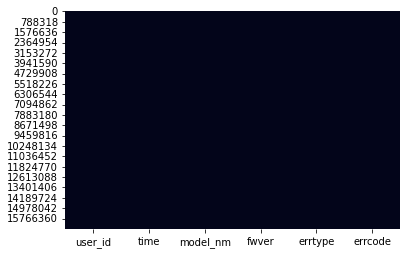

In [24]:
sns.heatmap(train_err_df.isnull(), cbar=False)

<AxesSubplot:>

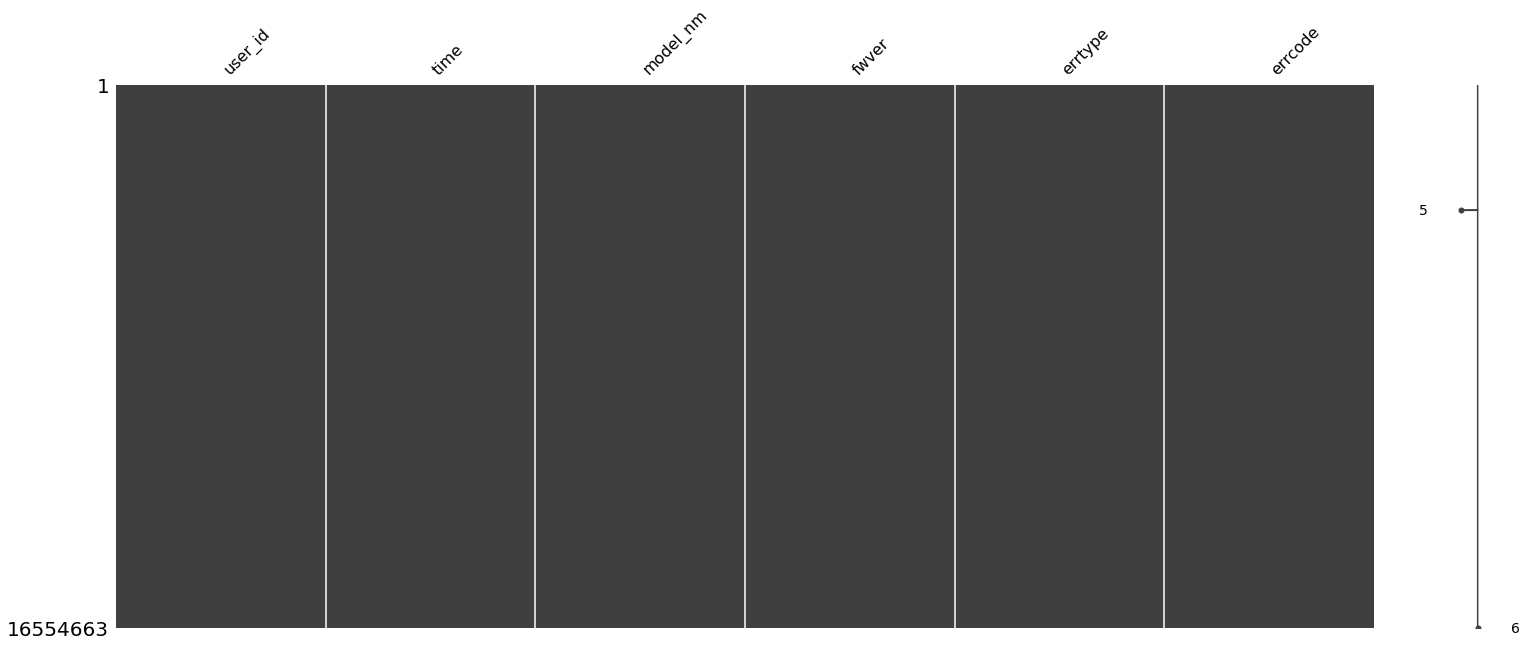

In [28]:
msno.matrix(train_err_df)

In [37]:

problem[train_problem_df.user_id.unique()]

array([19224, 23664, 15166, ..., 19114, 21505, 18822])

In [ ]:
\